In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import os
import sys
import seaborn as sns
import random
from collections import Counter
from functools import partial
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, BaseCrossValidator, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb

import sys
sys.path.append('../tools')
import kentai
import lgbmtools
import calc_3class

In [2]:
projectdir = os.environ['PROJECT_DIR']         # Project directory
projectdir = Path(projectdir)
datadir = projectdir / 'data'                  # Data directory
pulsedir = datadir / 'pulse'                   # Pulse directory
Infldir = pulsedir / 'Infl20230106'            # Influenza pulse directory
Coviddir = pulsedir / 'SARS-CoV-2'             # Covid pulse directory
NCdir = pulsedir / 'NC'                        # NC directory
featuredir = datadir / 'feature'               # Feature directory
resultdir = datadir / 'result'                 # Result directory
featurepath = featuredir / 'features.csv'      # Path to features file
idlabelspath = featuredir / 'idlabels.csv'     # Path to idlabels file

In [3]:
kentai = kentai.Kentai(featurepath, idlabelspath)

In [4]:
kentai.count_instance()

,pid,pulse
label,,
covid,40,45742
infl,59,55449
nc,106,70815


In [6]:
experiment_base_name = 'Tsfresh_InflCovidNC'
experiment_name = 'InflNC'
experiment_dir = resultdir / experiment_base_name / experiment_name
os.makedirs(experiment_dir, exist_ok=True) 

pid_random_states = range(0, 500)  # 500 random states for PID sampling
us_random_state = 0  # Random state for under-sampling
tv_random_state = 0  # Random state for train/validation split
evalfunc = partial(f1_score, average='macro')  # Evaluation function
n_pid_split_dict = {'infl': [29, 30], 'nc': [30, 30]}  # Number of train/test samples per class
labels = list(n_pid_split_dict.keys())  # Class labels
num_class = len(n_pid_split_dict)  # Number of classes
le = LabelEncoder()  # Label encoder
le.fit(labels)
label_column = 'label'

for i, (df_X, df_y, splitted_pids, splitted_pidlabels) \
    in enumerate(kentai.generate_dfxypidspidlabels(
            n_pid_split_dict, random_states=pid_random_states, label_column=label_column)):

    outputdirname = 'ex-division' + str(i).zfill(2)  # Name of the directory where results will be saved
    outputdir = experiment_dir / outputdirname  # Directory where results will be saved
    os.makedirs(outputdir, exist_ok=True)  # Create it if it does not exist

    # Save PIDs used in the experiment
    splitted_pidsfilepath = outputdir / 'splitted_pids.csv'
    with open(splitted_pidsfilepath, mode='w') as f:
        for pids in splitted_pids:
            # Without reshape, they would be written line by line instead of comma-separated
            np.savetxt(f, np.array(pids).reshape(1, -1), delimiter=',', fmt='%d')

    # Save PID labels used in the experiment
    splitted_pidlabelsfilepath = outputdir / 'splitted_pidlabels.csv'  # File to store PIDs used in the experiment
    with open(splitted_pidlabelsfilepath, mode='w') as f:
        for pidlabels in splitted_pidlabels:
            # Without reshape, they would be written line by line instead of comma-separated
            np.savetxt(f, np.array(pidlabels).reshape(1, -1), delimiter=',', fmt='%s')

    df_X_train, df_X_test = df_X  # Feature vectors for each instance
    df_y_train, df_y_test = df_y  # Labels for each instance
    pids_train, pids_test = splitted_pids  # PIDs used for train/test
    pidlabels_train, pidlabels_test = splitted_pidlabels  # Labels of PIDs used for train/test

    # RandomUnderSampling without NR
    rus = RandomUnderSampler(random_state=us_random_state)
    df_X_train_resampled, y_train_resampled = rus.fit_resample(df_X_train, df_y_train[label_column])
    df_y_train_resampled = df_y_train.loc[df_X_train_resampled.index]

    # Split validation data for early_stopping_rounds
    df_X_train_resampled_train, df_X_train_resampled_valid, \
    df_y_train_resampled_train, df_y_train_resampled_valid = \
        train_test_split(df_X_train_resampled, df_y_train_resampled, test_size=0.2,
                         random_state=tv_random_state,
                         stratify=df_y_train_resampled[label_column])

    # Set parameters
    if len(n_pid_split_dict) == 2:
        objective = 'binary'
        metric = 'binary_logloss'
        num_class = 1  # Number of classes (for binary, it is 1 for some reason)
        eval_metric = 'binary_logloss'
    else:
        objective = 'multiclass'
        metric = 'multi_logloss'
        num_class = len(n_pid_split_dict)  # Number of classes
        eval_metric = 'multi_logloss'

    lgb_params = {
        'n_estimators': 10000,
        'objective': objective,
        'metric': metric,
        'num_class': num_class,  # Number of classes
        'seed': 0
    }

    fit_params = {
        'eval_metric': eval_metric,  # Metric used for early_stopping_rounds
        'eval_set': [(df_X_train_resampled_valid.to_numpy(),
                      df_y_train_resampled_valid[label_column])],
        'callbacks': [lgb.early_stopping(stopping_rounds=100, verbose=True)]
    }

    # Train classifier
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(df_X_train_resampled_train.values,
            df_y_train_resampled_train[label_column],
            **fit_params)

    # Instance-level results
    y_pred_probs = clf.predict_proba(df_X_test)  # Predicted probabilities for each label
    y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted label indices
    y_pred = le.inverse_transform(y_pred)     # Decode labels

    # Save instance-level results
    case_pred_probs_path = outputdir / 'case_nonr_pred_probs.csv'  # File to save predicted probabilities per instance
    df_case_nonr_pred_probs = pd.DataFrame(y_pred_probs, columns=labels)
    df_case_nonr_pred_probs.to_csv(case_pred_probs_path, index=None)

    case_nonr_true_pred_path = outputdir / 'case_nonr_true_pred.csv'  # File to save true and predicted labels per instance
    df_case_nonr_true_pred = pd.DataFrame(
        np.array([df_y_test[label_column], y_pred]).T,
        columns=(['true', 'pred'])
    )
    df_case_nonr_true_pred.to_csv(case_nonr_true_pred_path, index=None)
    lgbmtools.save_clrep_confmat(df_y_test[label_column], y_pred, labels,
                                 filenamehead='case_nonr', outputdir=outputdir)

    # PID-level results

    # Compute predicted probabilities aggregated by PID
    # pidlabels_pred_probs = pred_ratio_bypid(pids_test, df_y_test['pid'], y_pred, labels)  # Prediction ratio per PID
    pidlabels_pred_probs = lgbmtools.pred_probsum_bypid(
        pids_test,
        df_y_test['pid'].to_numpy(),
        y_pred_probs,
        labels
    )  # Sum of prediction probabilities per PID

    df_pidlabels_pred_probs = pd.DataFrame(pidlabels_pred_probs, columns=labels)
    # Save
    pid_pred_probs_path = outputdir / 'pid_nonr_pred_probs.csv'  # File to save prediction probabilities per PID
    df_pidlabels_pred_probs.to_csv(pid_pred_probs_path, index=None)

    # Predicted labels per PID
    pidlabels_pred = np.argmax(pidlabels_pred_probs, axis=1)  # Predicted label indices
    pidlabels_pred = le.inverse_transform(pidlabels_pred)     # Decode labels
    df_pids_pidlabels_pidpred = pd.DataFrame(
        np.array([pids_test, pidlabels_test, pidlabels_pred]).T,
        columns=(['pid', 'true', 'pred'])
    )
    # Save
    pids_pidlabels_pidpred_path = outputdir / 'pid_nonr_true_pred.csv'  # File to save true and predicted labels per PID
    df_pids_pidlabels_pidpred.to_csv(pids_pidlabels_pidpred_path, index=None)

    # Evaluation metrics (PID-level)
    lgbmtools.save_clrep_confmat(
        pidlabels_test,
        pidlabels_pred,
        labels,
        filenamehead='pid_nonr',
        outputdir=outputdir
    )

    # Predictions on validation data
    y_pred_prob1 = clf.predict_proba(df_X_train_resampled_valid)
    y_pred1 = np.argmax(y_pred_prob1, axis=1)
    y_pred1 = le.inverse_transform(y_pred1)

    # Save classification report and confusion matrix for validation data
    lgbmtools.save_clrep_confmat(
        df_y_train_resampled_valid[label_column],
        y_pred1,
        labels,
        filenamehead='case_nonr_valid',
        outputdir=outputdir
    )

    # Save validation instances
    y_pred_prob1_path = outputdir / 'case_nonr_valid_pred_probs.csv'
    df_case_nonr_pred_prob1 = pd.DataFrame(y_pred_prob1, columns=labels)
    df_case_nonr_pred_prob1.to_csv(y_pred_prob1_path, index=None)

    case_nonr_true_pred1_path = outputdir / 'case_nonr_valid_true_pred.csv'
    df_case_nonr_true_pred1 = pd.DataFrame(
        np.array([df_y_train_resampled_valid[label_column], y_pred1]).T,
        columns=(['true', 'pred'])
    )
    df_case_nonr_true_pred1.to_csv(case_nonr_true_pred1_path, index=None)


[LightGBM] [Info] Number of positive: 16709, number of negative: 16708
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116248
[LightGBM] [Info] Number of data points in the train set: 33417, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500015 -> initscore=0.000060
[LightGBM] [Info] Start training from score 0.000060
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.524401
[LightGBM] [Info] Number of positive: 16325, number of negative: 16324
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116285
[LightGBM] [Info] Number of data points in the train set: 32649, number of used features: 474
[Lig

case_nonr


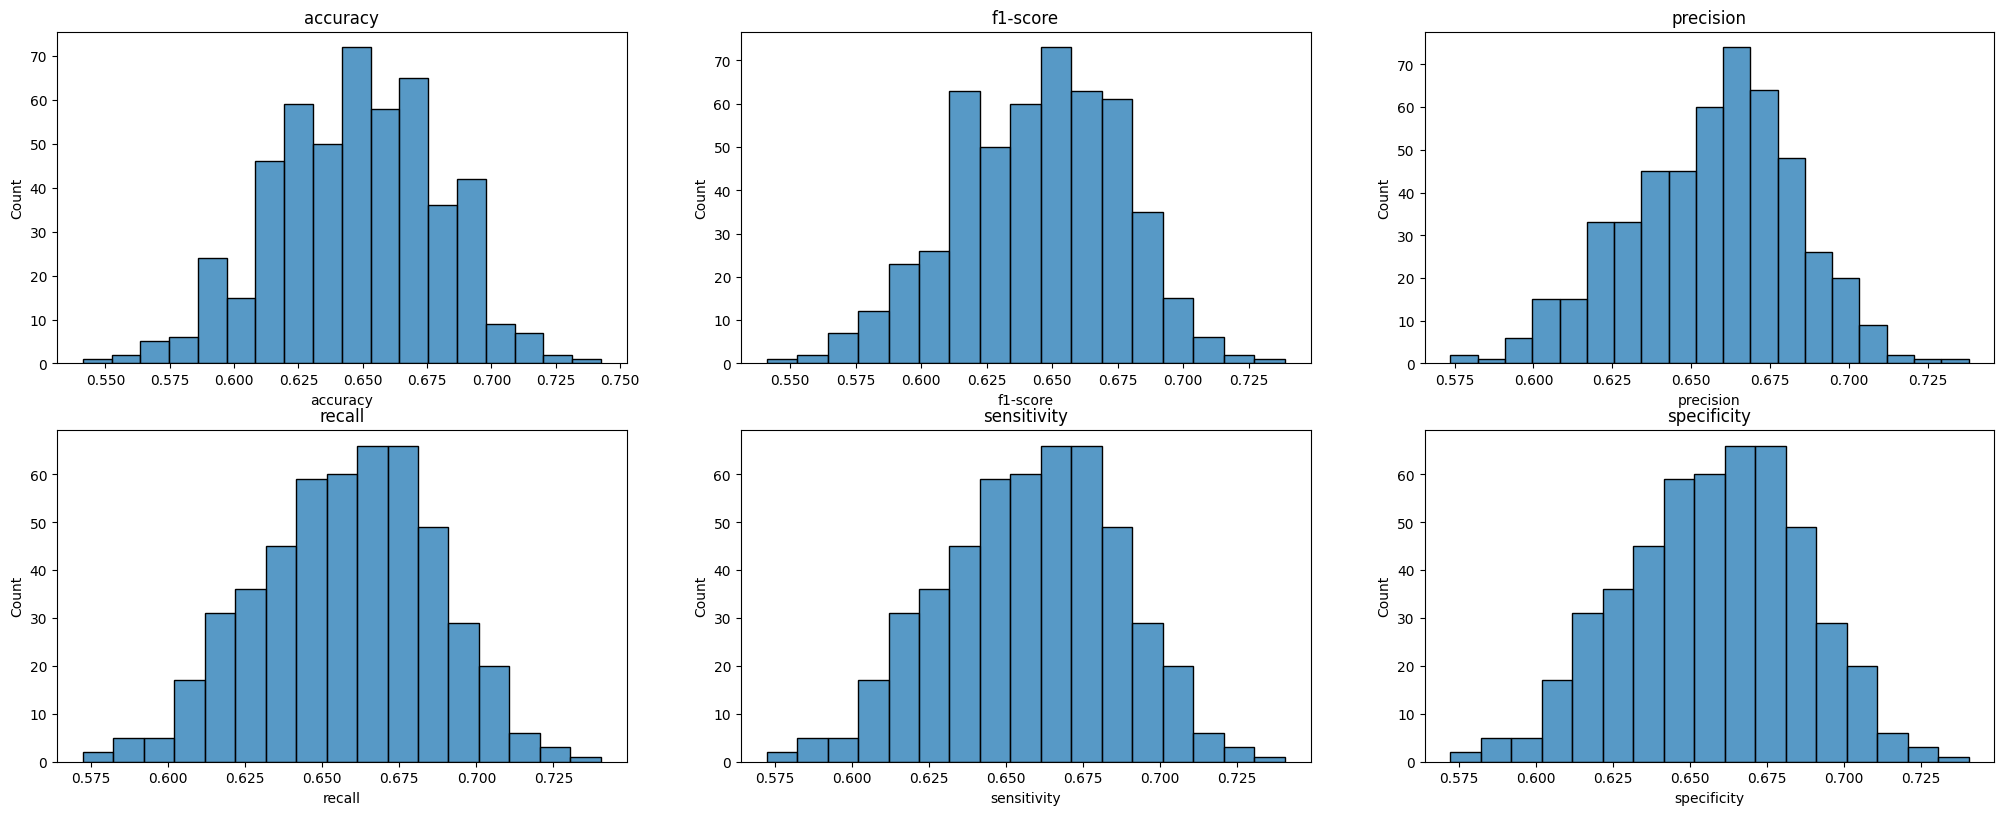

,accuracy,f1-score,precision,recall,sensitivity,specificity
count,500.0,500.0,500.0,500.0,500.0,500.0
mean,0.647393,0.644096,0.656294,0.657999,0.657999,0.657999
std,0.032143,0.031651,0.026504,0.02846,0.02846,0.02846
min,0.541231,0.541052,0.573702,0.57226,0.57226,0.57226
25%,0.624537,0.620571,0.639306,0.637672,0.637672,0.637672
50%,0.648303,0.647092,0.659103,0.660245,0.660245,0.660245
75%,0.670813,0.668615,0.674985,0.677469,0.677469,0.677469
max,0.742488,0.73874,0.737823,0.740416,0.740416,0.740416
max file,ex-division330,ex-division330,ex-division330,ex-division330,ex-division330,ex-division330


,infl,nc
infl,24752,8032
nc,6752,17875


pid_nonr


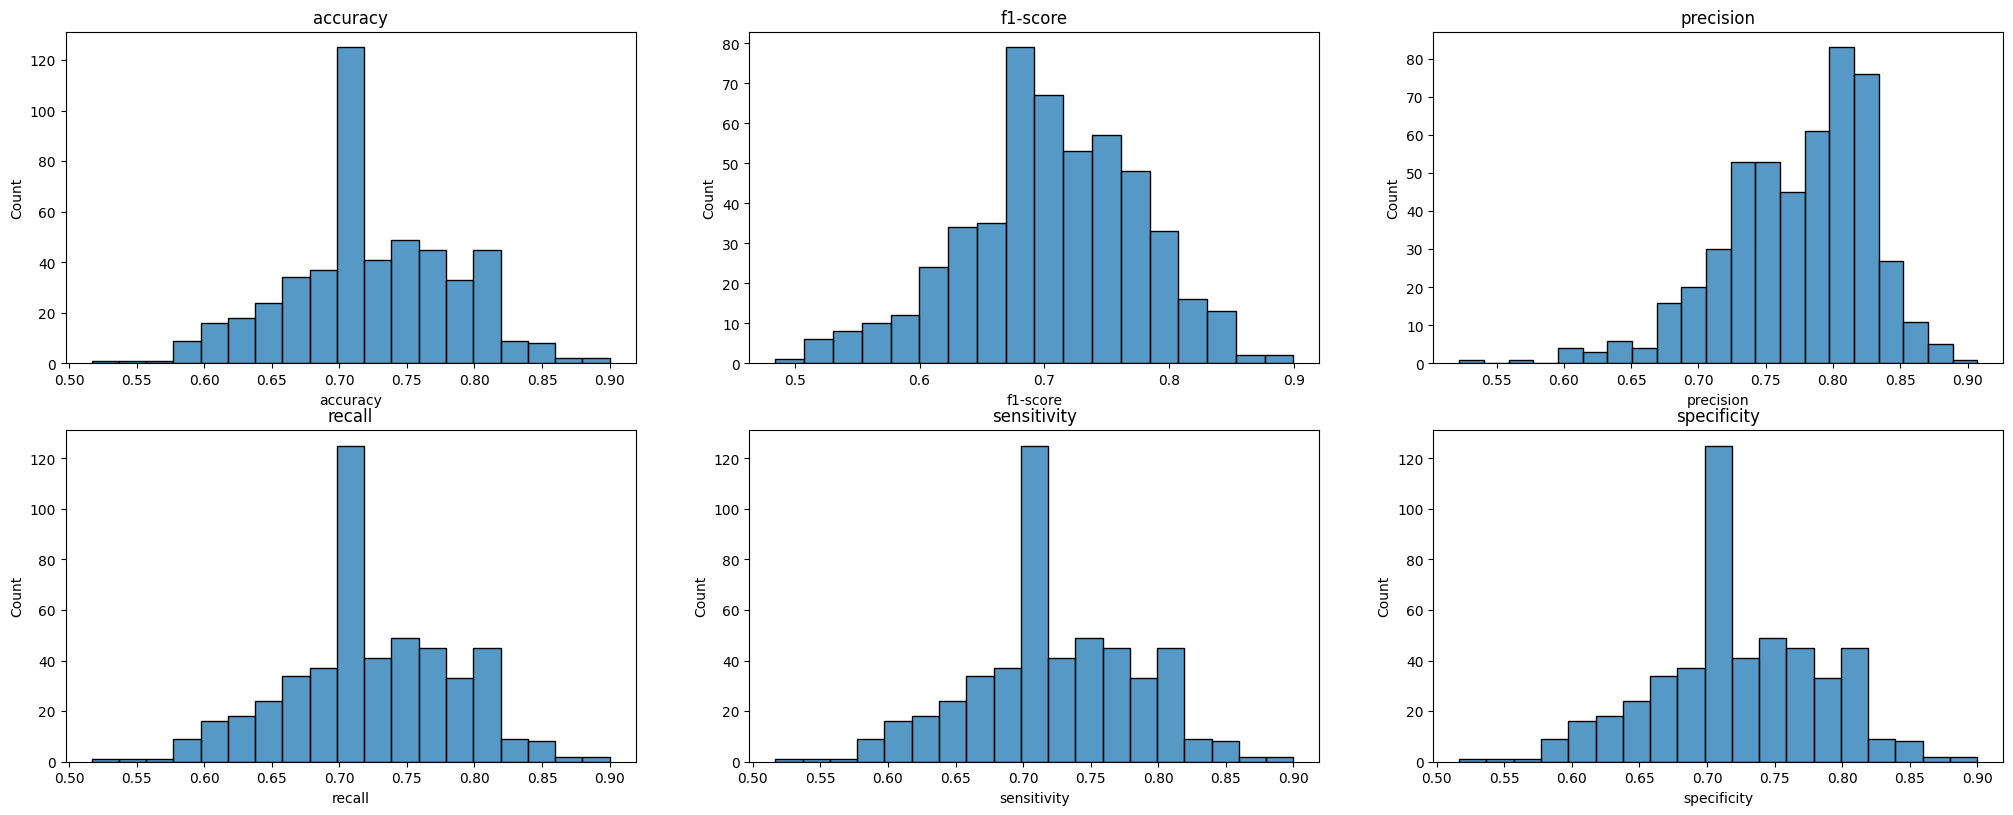

,accuracy,f1-score,precision,recall,sensitivity,specificity
count,500.0,500.0,500.0,500.0,500.0,500.0
mean,0.722533,0.707004,0.772973,0.722533,0.722533,0.722533
std,0.060715,0.071552,0.054946,0.060715,0.060715,0.060715
min,0.516667,0.484444,0.522222,0.516667,0.516667,0.516667
25%,0.683333,0.667735,0.738095,0.683333,0.683333,0.683333
50%,0.716667,0.706812,0.779503,0.716667,0.716667,0.716667
75%,0.766667,0.76,0.8125,0.766667,0.766667,0.766667
max,0.9,0.899554,0.90724,0.9,0.9,0.9
max file,ex-division79,ex-division79,ex-division79,ex-division79,ex-division79,ex-division79


,infl,nc
infl,25,5
nc,1,29


In [7]:
lgbmtools.calc_save_ave_2class_maxf1(experiment_dir, labels, target_label='macro avg')

In [8]:
experiment_base_name = 'Tsfresh_InflCovidNC'
experiment_name = 'CovidNC'
experiment_dir = resultdir / experiment_base_name / experiment_name
os.makedirs(experiment_dir, exist_ok=True) 

pid_random_states = range(0,300)  # 300 random states for PID sampling
us_random_state = 0  # Random state for under-sampling
tv_random_state = 0  # Random state for train/validation split
evalfunc = partial(f1_score, average='macro')  # Evaluation function
n_pid_split_dict = {'covid': [20, 20], 'nc': [20, 20]}  # Number of train/test samples per class
labels = list(n_pid_split_dict.keys())  # Class labels
num_class = len(n_pid_split_dict)  # Number of classes
le = LabelEncoder()  # Label encoder
le.fit(labels)    
label_column = 'label'

for i, (df_X, df_y, splitted_pids, splitted_pidlabels) \
    in enumerate(kentai.generate_dfxypidspidlabels(
            n_pid_split_dict, random_states=pid_random_states, label_column=label_column)):

    outputdirname = 'ex-division' + str(i).zfill(2)  # Name of the directory where results will be saved
    outputdir = experiment_dir / outputdirname       # Directory where results will be saved
    os.makedirs(outputdir, exist_ok=True)           # Create it if it does not exist

    # Save PIDs used in the experiment
    splitted_pidsfilepath = outputdir / 'splitted_pids.csv'
    with open(splitted_pidsfilepath, mode='w') as f:
        for pids in splitted_pids:
            # Without reshape, it would not be comma-separated but written line by line
            np.savetxt(f, np.array(pids).reshape(1, -1), delimiter=',', fmt='%d')

    # Save PID labels used in the experiment
    splitted_pidlabelsfilepath = outputdir / 'splitted_pidlabels.csv'  # File to store PIDs used in the experiment
    with open(splitted_pidlabelsfilepath, mode='w') as f:
        for pidlabels in splitted_pidlabels:
            # Without reshape, it would not be comma-separated but written line by line
            np.savetxt(f, np.array(pidlabels).reshape(1, -1), delimiter=',', fmt='%s')

    df_X_train, df_X_test = df_X  # Feature vectors for each instance
    df_y_train, df_y_test = df_y  # Labels for each instance
    pids_train, pids_test = splitted_pids  # PIDs used for train/test
    pidlabels_train, pidlabels_test = splitted_pidlabels  # Labels of PIDs used for train/test

    # RandomUnderSampling without NR
    rus = RandomUnderSampler(random_state=us_random_state)
    df_X_train_resampled, y_train_resampled = rus.fit_resample(df_X_train, df_y_train[label_column])
    df_y_train_resampled = df_y_train.loc[df_X_train_resampled.index]

    # Split validation data for early_stopping_rounds
    df_X_train_resampled_train, df_X_train_resampled_valid, \
    df_y_train_resampled_train, df_y_train_resampled_valid = \
        train_test_split(df_X_train_resampled, df_y_train_resampled, test_size=0.2,
                         random_state=tv_random_state,
                         stratify=df_y_train_resampled[label_column])

    # Set parameters
    if len(n_pid_split_dict) == 2:
        objective = 'binary'
        metric = 'binary_logloss'
        num_class = 1  # Number of classes (for binary it is 1)
        eval_metric = 'binary_logloss'
    else:
        objective = 'multiclass'
        metric = 'multi_logloss'
        num_class = len(n_pid_split_dict)  # Number of classes
        eval_metric = 'multi_logloss'

    lgb_params = {
        'n_estimators': 10000,
        'objective': objective,
        'metric': metric,
        'num_class': num_class,  # Number of classes
        'seed': 0
    }
        
    fit_params = {
        'eval_metric': eval_metric,  # Metric used for early_stopping_rounds
        'eval_set': [(df_X_train_resampled_valid.to_numpy(),
                      df_y_train_resampled_valid[label_column])],
        'callbacks': [lgb.early_stopping(stopping_rounds=100, verbose=True)]
    }

    # Train classifier
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(df_X_train_resampled_train.values,
            df_y_train_resampled_train[label_column],
            **fit_params)

    # Instance-level results
    y_pred_probs = clf.predict_proba(df_X_test)  # Predicted probabilities for each label
    y_pred = np.argmax(y_pred_probs, axis=1)     # Predicted label indices
    y_pred = le.inverse_transform(y_pred)        # Decode labels

    # Save instance-level results
    case_pred_probs_path = outputdir / 'case_nonr_pred_probs.csv'  # File to save predicted probabilities per instance
    df_case_nonr_pred_probs = pd.DataFrame(y_pred_probs, columns=labels)
    df_case_nonr_pred_probs.to_csv(case_pred_probs_path, index=None)

    case_nonr_true_pred_path = outputdir / 'case_nonr_true_pred.csv'  # File to save true and predicted labels per instance
    df_case_nonr_true_pred = pd.DataFrame(
        np.array([df_y_test[label_column], y_pred]).T,
        columns=(['true', 'pred'])
    )
    df_case_nonr_true_pred.to_csv(case_nonr_true_pred_path, index=None)
    lgbmtools.save_clrep_confmat(df_y_test[label_column], y_pred, labels,
                                 filenamehead='case_nonr', outputdir=outputdir)

    # PID-level results

    # Compute predicted probabilities aggregated by PID
    # pidlabels_pred_probs = pred_ratio_bypid(pids_test, df_y_test['pid'], y_pred, labels)  # Prediction ratio per PID
    pidlabels_pred_probs = lgbmtools.pred_probsum_bypid(
        pids_test,
        df_y_test['pid'].to_numpy(),
        y_pred_probs,
        labels
    )  # Sum of prediction probabilities per PID

    df_pidlabels_pred_probs = pd.DataFrame(pidlabels_pred_probs, columns=labels)
    # Save
    pid_pred_probs_path = outputdir / 'pid_nonr_pred_probs.csv'  # File to save prediction probabilities per PID
    df_pidlabels_pred_probs.to_csv(pid_pred_probs_path, index=None)            
        
    # Predicted labels per PID
    pidlabels_pred = np.argmax(pidlabels_pred_probs, axis=1)  # Predicted label indices
    pidlabels_pred = le.inverse_transform(pidlabels_pred)     # Decode labels
    df_pids_pidlabels_pidpred = pd.DataFrame(
        np.array([pids_test, pidlabels_test, pidlabels_pred]).T,
        columns=(['pid', 'true', 'pred'])
    )
    # Save
    pids_pidlabels_pidpred_path = outputdir / 'pid_nonr_true_pred.csv'  # File to save true and predicted labels per PID
    df_pids_pidlabels_pidpred.to_csv(pids_pidlabels_pidpred_path, index=None)

    # Evaluation metrics (PID-level)
    lgbmtools.save_clrep_confmat(
        pidlabels_test,
        pidlabels_pred,
        labels,
        filenamehead='pid_nonr',
        outputdir=outputdir
    )

    # Predictions on validation data
    y_pred_prob1 = clf.predict_proba(df_X_train_resampled_valid)
    y_pred1 = np.argmax(y_pred_prob1, axis=1)
    y_pred1 = le.inverse_transform(y_pred1)

    # Save classification report and confusion matrix for validation data
    lgbmtools.save_clrep_confmat(
        df_y_train_resampled_valid[label_column],
        y_pred1,
        labels,
        filenamehead='case_nonr_valid',
        outputdir=outputdir
    )

    # Save validation instances
    y_pred_prob1_path = outputdir / 'case_nonr_valid_pred_probs.csv'
    df_case_nonr_pred_prob1 = pd.DataFrame(y_pred_prob1, columns=labels)
    df_case_nonr_pred_prob1.to_csv(y_pred_prob1_path, index=None)

    case_nonr_true_pred1_path = outputdir / 'case_nonr_valid_true_pred.csv'
    df_case_nonr_true_pred1 = pd.DataFrame(
        np.array([df_y_train_resampled_valid[label_column], y_pred1]).T,
        columns=(['true', 'pred'])
    )
    df_case_nonr_true_pred1.to_csv(case_nonr_true_pred1_path, index=None)


[LightGBM] [Info] Number of positive: 13688, number of negative: 13688
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116151
[LightGBM] [Info] Number of data points in the train set: 27376, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.456644
[LightGBM] [Info] Number of positive: 10850, number of negative: 10850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116141
[LightGBM] [Info] Number of data points in the train set: 21700, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -

case_nonr


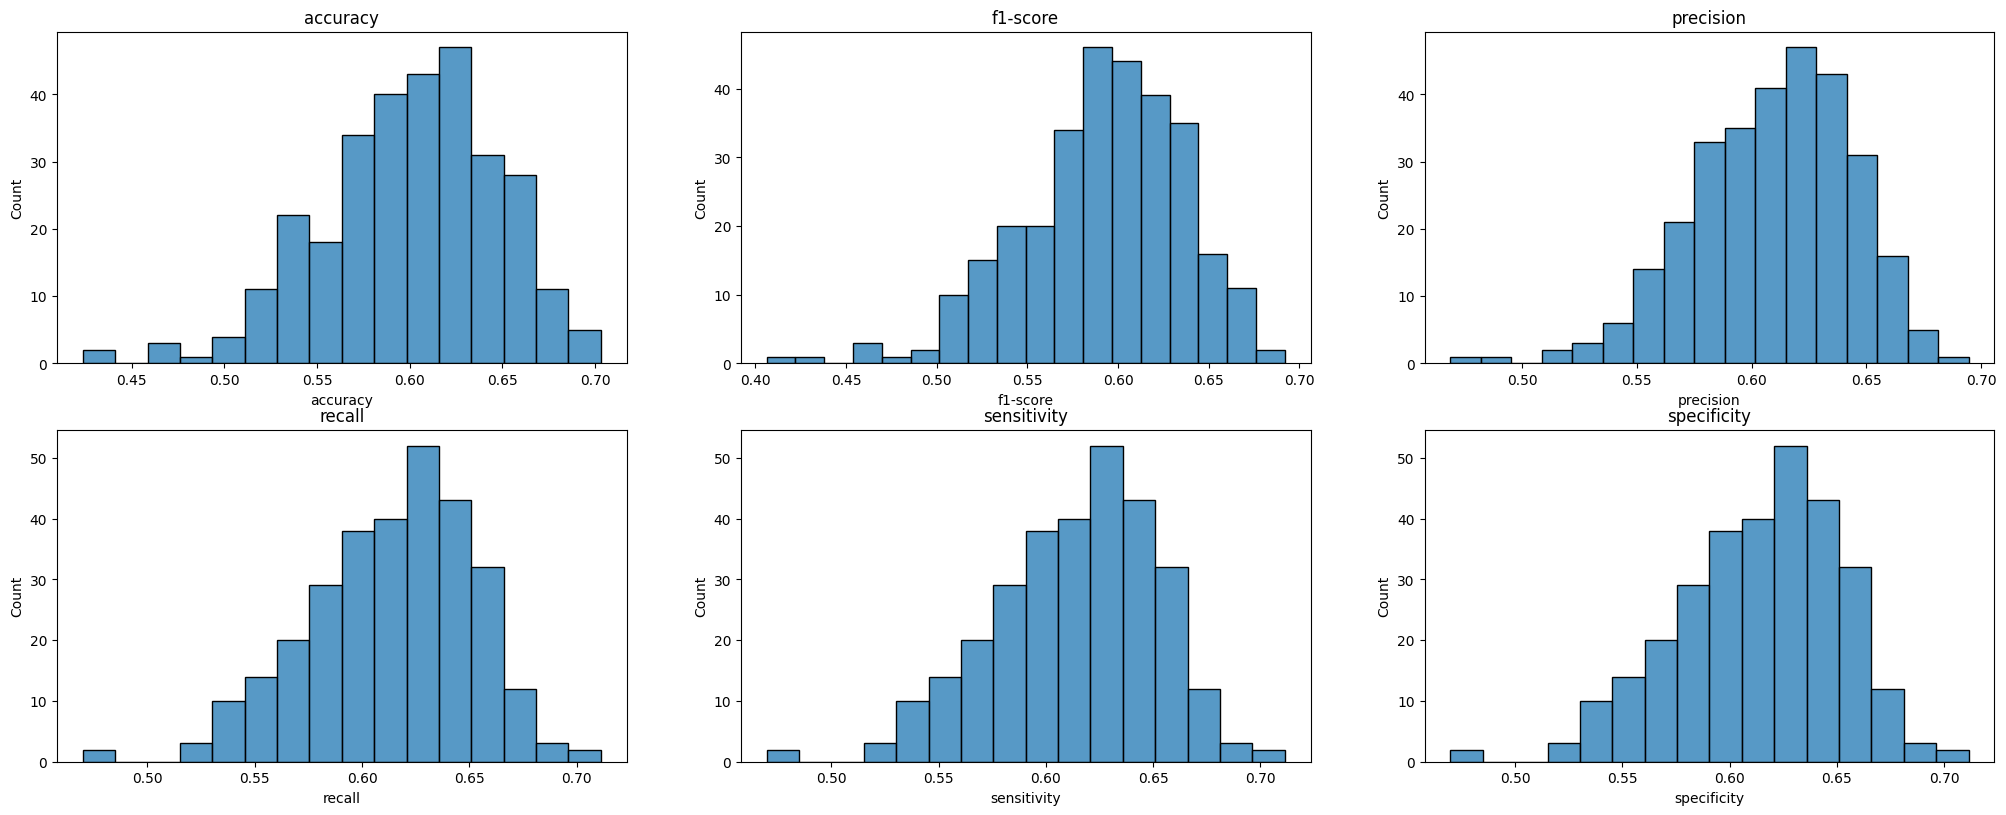

,accuracy,f1-score,precision,recall,sensitivity,specificity
count,300.0,300.0,300.0,300.0,300.0,300.0
mean,0.599989,0.591102,0.608737,0.614098,0.614098,0.614098
std,0.047659,0.045085,0.035012,0.038513,0.038513,0.038513
min,0.423681,0.406223,0.468769,0.469855,0.469855,0.469855
25%,0.571843,0.566382,0.585824,0.589082,0.589082,0.589082
50%,0.604937,0.594202,0.611736,0.619172,0.619172,0.619172
75%,0.633279,0.622404,0.632702,0.641685,0.641685,0.641685
max,0.703141,0.69192,0.694468,0.711332,0.711332,0.711332
max file,ex-division173,ex-division52,ex-division52,ex-division52,ex-division52,ex-division52


,covid,nc
covid,15839,7717
nc,3270,9824


pid_nonr


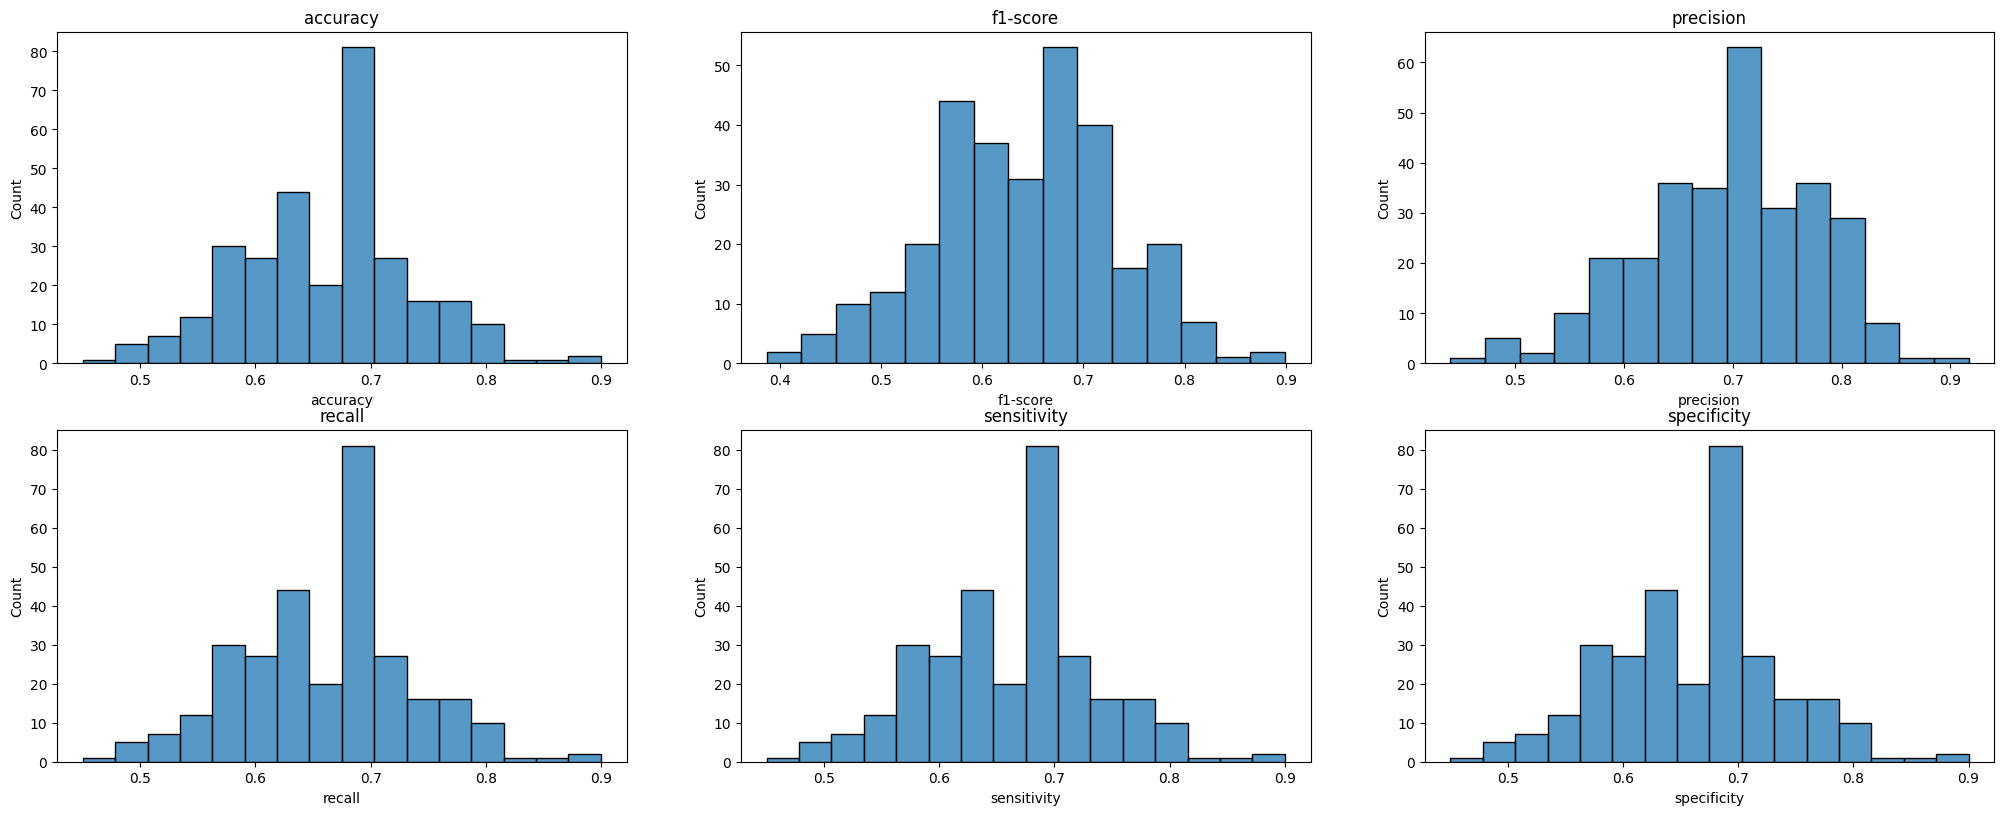

,accuracy,f1-score,precision,recall,sensitivity,specificity
count,300.0,300.0,300.0,300.0,300.0,300.0
mean,0.66075,0.64126,0.697593,0.66075,0.66075,0.66075
std,0.07548,0.089723,0.079288,0.07548,0.07548,0.07548
min,0.45,0.386602,0.440476,0.45,0.45,0.45
25%,0.6,0.579218,0.65,0.6,0.6,0.6
50%,0.675,0.648411,0.70101,0.675,0.675,0.675
75%,0.7,0.699248,0.757412,0.7,0.7,0.7
max,0.9,0.89899,0.916667,0.9,0.9,0.9
max file,ex-division207,ex-division207,ex-division207,ex-division207,ex-division207,ex-division207


,covid,nc
covid,16,4
nc,0,20


In [9]:
lgbmtools.calc_save_ave_2class_maxf1(experiment_dir, labels, target_label='macro avg')

In [10]:
experiment_base_name = 'Tsfresh_InflCovidNC'
experiment_name = 'InflCovidNC'
experiment_dir = resultdir / experiment_base_name / experiment_name
os.makedirs(experiment_dir, exist_ok=True) 

pid_random_states = range(0, 500)  # 500 random states for PID sampling
us_random_state = 0  # Random state for under-sampling
tv_random_state = 0  # Random state for train/validation split
evalfunc = partial(f1_score, average='macro')  # Evaluation function
n_pid_split_dict = {'infl': [20, 20], 'covid': [20, 20], 'nc': [20, 20]}  # Number of train/test samples per class
labels = list(n_pid_split_dict.keys())  # Class labels
num_class = len(n_pid_split_dict)  # Number of classes
le = LabelEncoder()  # Label encoder
le.fit(labels)
label_column = 'label'

for i, (df_X, df_y, splitted_pids, splitted_pidlabels) \
    in enumerate(kentai.generate_dfxypidspidlabels(
            n_pid_split_dict, random_states=pid_random_states, label_column=label_column)):

    outputdirname = 'ex-division' + str(i).zfill(2)  # Name of the directory where results will be saved
    outputdir = experiment_dir / outputdirname       # Directory where results will be saved
    os.makedirs(outputdir, exist_ok=True)           # Create it if it does not exist

    # Save PIDs used in the experiment
    splitted_pidsfilepath = outputdir / 'splitted_pids.csv'
    with open(splitted_pidsfilepath, mode='w') as f:
        for pids in splitted_pids:
            # Without reshape, values are written line by line instead of comma-separated
            np.savetxt(f, np.array(pids).reshape(1, -1), delimiter=',', fmt='%d')

    # Save PID labels used in the experiment
    splitted_pidlabelsfilepath = outputdir / 'splitted_pidlabels.csv'  # File to store PIDs used in the experiment
    with open(splitted_pidlabelsfilepath, mode='w') as f:
        for pidlabels in splitted_pidlabels:
            # Without reshape, values are written line by line instead of comma-separated
            np.savetxt(f, np.array(pidlabels).reshape(1, -1), delimiter=',', fmt='%s')

    df_X_train, df_X_test = df_X  # Feature vectors for each instance
    df_y_train, df_y_test = df_y  # Labels for each instance
    pids_train, pids_test = splitted_pids  # PIDs used for train/test
    pidlabels_train, pidlabels_test = splitted_pidlabels  # Labels of PIDs used for train/test

    # RandomUnderSampler without NR
    rus = RandomUnderSampler(random_state=us_random_state)
    df_X_train_resampled, y_train_resampled = rus.fit_resample(df_X_train, df_y_train[label_column])
    df_y_train_resampled = df_y_train.loc[df_X_train_resampled.index]

    # Split validation data for early_stopping_rounds
    df_X_train_resampled_train, df_X_train_resampled_valid, \
    df_y_train_resampled_train, df_y_train_resampled_valid = \
        train_test_split(df_X_train_resampled, df_y_train_resampled, test_size=0.2,
                         random_state=tv_random_state,
                         stratify=df_y_train_resampled[label_column])

    # Set parameters
    if len(n_pid_split_dict) == 2:
        objective = 'binary'
        metric = 'binary_logloss'
        num_class = 1  # Number of classes (1 in the binary case)
        eval_metric = 'binary_logloss'
    else:
        objective = 'multiclass'
        metric = 'multi_logloss'
        num_class = len(n_pid_split_dict)  # Number of classes
        eval_metric = 'multi_logloss'

    lgb_params = {
        'n_estimators': 10000,
        'objective': objective,
        'metric': metric,
        'num_class': num_class,  # Number of classes
        'seed': 0
    }
        
    fit_params = {
        'eval_metric': eval_metric,  # Metric used for early_stopping_rounds
        'eval_set': [(df_X_train_resampled_valid.to_numpy(),
                      df_y_train_resampled_valid[label_column])],
        'callbacks': [lgb.early_stopping(stopping_rounds=100, verbose=True)]
    }

    # Train classifier
    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(df_X_train_resampled_train.values,
            df_y_train_resampled_train[label_column],
            **fit_params)

    # Instance-level results
    y_pred_probs = clf.predict_proba(df_X_test)  # Predicted probabilities for each label
    y_pred = np.argmax(y_pred_probs, axis=1)     # Predicted label indices
    y_pred = le.inverse_transform(y_pred)        # Decode labels

    # Save instance-level results
    case_pred_probs_path = outputdir / 'case_nonr_pred_probs.csv'  # File to save predicted probabilities per instance
    df_case_nonr_pred_probs = pd.DataFrame(y_pred_probs, columns=labels)
    df_case_nonr_pred_probs.to_csv(case_pred_probs_path, index=None)

    case_nonr_true_pred_path = outputdir / 'case_nonr_true_pred.csv'  # File to save true and predicted labels per instance
    df_case_nonr_true_pred = pd.DataFrame(
        np.array([df_y_test[label_column], y_pred]).T,
        columns=(['true', 'pred'])
    )
    df_case_nonr_true_pred.to_csv(case_nonr_true_pred_path, index=None)
    lgbmtools.save_clrep_confmat(df_y_test[label_column], y_pred, labels,
                                 filenamehead='case_nonr', outputdir=outputdir)

    # PID-level results

    # Compute predicted probabilities aggregated by PID
    # pidlabels_pred_probs = pred_ratio_bypid(pids_test, df_y_test['pid'], y_pred, labels)  # Prediction ratio per PID
    pidlabels_pred_probs = lgbmtools.pred_probsum_bypid(
        pids_test,
        df_y_test['pid'].to_numpy(),
        y_pred_probs,
        labels
    )  # Sum of predicted probabilities per PID

    df_pidlabels_pred_probs = pd.DataFrame(pidlabels_pred_probs, columns=labels)
    # Save
    pid_pred_probs_path = outputdir / 'pid_nonr_pred_probs.csv'  # File to save predicted probabilities per PID
    df_pidlabels_pred_probs.to_csv(pid_pred_probs_path, index=None)            
        
    # Predicted labels per PID
    pidlabels_pred = np.argmax(pidlabels_pred_probs, axis=1)  # Predicted label indices
    pidlabels_pred = le.inverse_transform(pidlabels_pred)     # Decode labels
    df_pids_pidlabels_pidpred = pd.DataFrame(
        np.array([pids_test, pidlabels_test, pidlabels_pred]).T,
        columns=(['pid', 'true', 'pred'])
    )
    # Save
    pids_pidlabels_pidpred_path = outputdir / 'pid_nonr_true_pred.csv'  # File to save true and predicted labels per PID
    df_pids_pidlabels_pidpred.to_csv(pids_pidlabels_pidpred_path, index=None)

    # Evaluation metrics (PID-level)
    lgbmtools.save_clrep_confmat(
        pidlabels_test,
        pidlabels_pred,
        labels,
        filenamehead='pid_nonr',
        outputdir=outputdir
    )

    # Predictions on validation data
    y_pred_prob1 = clf.predict_proba(df_X_train_resampled_valid)
    y_pred1 = np.argmax(y_pred_prob1, axis=1)
    y_pred1 = le.inverse_transform(y_pred1)

    # Save classification report and confusion matrix for validation data
    lgbmtools.save_clrep_confmat(
        df_y_train_resampled_valid[label_column],
        y_pred1,
        labels,
        filenamehead='case_nonr_valid',
        outputdir=outputdir
    )

    # Save validation instances
    y_pred_prob1_path = outputdir / 'case_nonr_valid_pred_probs.csv'
    df_case_nonr_pred_prob1 = pd.DataFrame(y_pred_prob1, columns=labels)
    df_case_nonr_pred_prob1.to_csv(y_pred_prob1_path, index=None)

    case_nonr_true_pred1_path = outputdir / 'case_nonr_valid_true_pred.csv'
    df_case_nonr_true_pred1 = pd.DataFrame(
        np.array([df_y_train_resampled_valid[label_column], y_pred1]).T,
        columns=(['true', 'pred'])
    )
    df_case_nonr_true_pred1.to_csv(case_nonr_true_pred1_path, index=None)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116398
[LightGBM] [Info] Number of data points in the train set: 41064, number of used features: 475
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	valid_0's multi_logloss: 0.744108
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 116371
[LightGBM] [Info] Number of data points in the train set: 32551, number of used features: 477
[LightGBM] [Info] Start training from score -1.098643
[LightGBM] [Info] Start training from score -1.098643
[LightGBM

In [13]:
calc_3class.calc_save_ave_3class(experiment_dir=experiment_dir, labels=labels, base_names=("case_nonr", "pid_nonr"), target_label="macro avg", save_hist=False)